# Exercise 4 - XGBoost

## Group *ID* : $2207$

### Members

- Pietro Cappelli
    - e-mail: pietro.cappelli@studenti.unipd.it
    - ID: 2058332
- Alberto Coppi
    - e-mail: alberto.coppi@studenti.unipd.it
    - ID: 2053063
- Giacomo Franceschetto
    - e-mail: giacomo.franceschetto@studenti.unipd.it
    - ID: 2053348
- Nicolò Lai
    - e-mail: nicolo.lai@studenti.unipd.it
    - ID: 2064377 
### Author contribution statement

Albicoppi did the entire exercise on his own. 

## Import libraries and custom modules

In [15]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import pandas            as pd

import keras
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D
from keras        import regularizers, initializers
from scipy.signal import detrend
from sklearn.metrics import accuracy_score

from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree

%load_ext autoreload
%autoreload 1
%aimport generate_data 
%aimport plot_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def standardize_sample(x):
    """rescale data sample-wise: for each sample subtract the mean and divide by std"""

    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]
    vm = np.std(x, axis=1)
    x = x/vm[:, np.newaxis]
    
    return x

def standardize_all(x):
    """rescale data semi-sample-wise: subtract the mean sample-wise then divide by the total std"""

    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]
    vm = np.std(x)
    x = x/vm

    return x


def keras_reshape(x):
    """reshape data to fit keras shape requirements"""
    
    return x.reshape(x.shape[0], x.shape[1], 1)


## Data parameters

In [4]:
N_list = [20, 50, 100, 150, 200, 250, 300, 400, 500]
N_stat = 10

seed_list = [12345 + i for i in range(0, N_stat)]

# time series data parameters
L       = 60
Z       = 12
A       = 500
DX      = 50
bias    = 5
n_class = 3  

input_shape = (L,1)

## Best performing CNN 

In [5]:
reg = regularizers.l2(0.02)
ini = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

NF    = 5 # number of filters

model_cnn = Sequential(name="giampaolo")


model_cnn.add(
    Conv1D(
        filters            = 6, 
        kernel_size        = 3, 
        kernel_initializer = ini,
        kernel_regularizer = reg,
        activation         = "relu",
        input_shape        = input_shape
    )
)
model_cnn.add(Conv1D(filters=8, kernel_size=9, activation="relu"))
model_cnn.add(Conv1D(filters=4, kernel_size=3, activation="relu"))
model_cnn.add(GlobalMaxPooling1D()) 
model_cnn.add(Flatten())
model_cnn.add(Dense(3, activation="softmax"))

print(model_cnn.summary())

opt = tf.keras.optimizers="Adam"

# save initial weights
initial_weights = model_cnn.get_weights()

# compile
model_cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=["accuracy"])

Model: "giampaolo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 6)             24        
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 8)             440       
                                                                 
 conv1d_2 (Conv1D)           (None, 48, 4)             100       
                                                                 
 global_max_pooling1d (Globa  (None, 4)                0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 3)                 15        
                                                         

2022-03-29 18:53:45.954247: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## CNN performance

In [6]:
class Dataset:

    def __init__(self, x, y, train_test_frac, valid_train_frac):

        self.x = x
        self.y = y

        N = x.shape[0]

        self.N_train = int(N*train_test_frac*(1-valid_train_frac))
        self.N_valid = int(N*train_test_frac*valid_train_frac)
        self.N_test  = int(N*(1-train_test_frac))

        self.train_idx = self.N_train
        self.valid_idx = self.N_train+self.N_valid
        self.test_idx  = self.N_train+self.N_valid+self.N_test

    @property
    def xtrain(self):
        return self.x[0:self.train_idx]

    @property
    def ytrain(self):
        return self.y[0:self.train_idx]

    @property
    def xvalid(self):
        return self.x[self.train_idx:self.valid_idx]

    @property
    def yvalid(self):
        return self.y[self.train_idx:self.valid_idx]

    @property
    def xtest(self):
        return self.x[self.valid_idx:self.test_idx]

    @property
    def ytest(self):
        return self.y[self.valid_idx:self.test_idx]

In [7]:
def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    #build id columns
    id_col = np.repeat(np.arange(N),t)
    #build time columns
    time_col = np.tile(np.arange(t),N)
    #build var columns
    x_col = x.flatten()
      
    #build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

In [8]:
BATCH_SIZE = 250
EPOCHS     = 100

# list for different N
# for each N create a dictionary
# dictionary contains:
#  - cnn mean accuracy
#  - cnn std
#  - xgboost mean accuracy
#  - xgboost std

performance_list = []

for N in N_list:
    cnn_performance     = []
    xgb_performance     = []
    for i, seed in zip(range(N_stat), seed_list):
    
        fname = generate_data.generate_data(N=N, seed=seed)

        # load data
        x = np.loadtxt("DATA/x_"+fname, delimiter=" ",dtype=float)
        # load categories
        c = np.loadtxt("DATA/y_"+fname, dtype=int)
        # build time grid
        t_grid = np.arange(0, L*N).reshape(N, L)
        # format labels from categories
        y = np.zeros((N, n_class))
        for i in range(N):
            y[i][c[i]] = 1

        # data rescaling
        x_detrend = detrend(x)
        x = standardize_all(x_detrend)

        ##### ---- CNN
        dataset = Dataset(x, y, train_test_frac=0.7 ,valid_train_frac=0.3)

        x_train = dataset.xtrain
        y_train = dataset.ytrain
        x_valid = dataset.xvalid
        y_valid = dataset.yvalid
        x_test  = dataset.xtest
        y_test  = dataset.ytest

        # reshape for keras
        x_train = keras_reshape(x_train)
        x_valid   = keras_reshape(x_valid)

        # reset model
        model_cnn.set_weights(initial_weights)

        # compile
        model_cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

        # fit CNN model
        fit = model_cnn.fit(
            x_train, 
            y_train, 
            batch_size      = BATCH_SIZE,
            epochs          = EPOCHS, 
            validation_data = (x_valid, y_valid),
            verbose         = 0, 
            shuffle         = True
        )

        # evaluate model on test dataset
        test = model_cnn.evaluate(
            x_test, y_test,
            batch_size      = BATCH_SIZE,
            verbose         = 0,
        )

        test_accuracy = test[1]

        cnn_performance.append(test_accuracy)
        ##### ----


        ##### ---- XGB boost
        df = get_df(x)

        #extract features
        x_features = extract_features(
            df, #our dataframe
            column_id='id', #sample id, from 0 to N
            column_sort='time', #timestep, from 0 to t
            column_kind=None, #we have only one feature
            column_value='value', #value of input 
            n_jobs=4 #number of cores
        ) 

        #remove columns with NaN or inf
        #x_features.replace([np.inf, -np.inf], np.nan)
        #x_features = x_features.dropna(axis='columns') 

        #split data into training and validation
        dataset = Dataset(x_features, y, train_test_frac=0.7 ,valid_train_frac=0.3)

        x_train = dataset.xtrain
        y_train = dataset.ytrain
        x_valid = dataset.xvalid
        y_valid = dataset.yvalid
        x_test  = dataset.xtest
        y_test  = dataset.ytest

        #rescale: in each feature, remove average and divide by std
        if True: 
            train_avg = np.mean(x_train,axis=0)
            test_avg  = np.mean(x_test,axis=0)
            x_train -= train_avg
            x_test  -= test_avg

            train_std = np.std(x_train,axis=0)
            test_std  = np.std(x_test,axis=0)
            x_train  /= train_std
            x_test  /= test_std 

        #define parameters for xgboost
        params = {'max_depth':6,'min_child_weight':1,\
                'learning_rate':0.3,'use_label_encoder':False}

        #build model with given params
        model_xgb = XGBClassifier(**params)

        #fit
        model_xgb.fit(x_train.values, np.argmax(y_train, axis=1))  

        
        #predict labels on test set
        y_pred_test = model_xgb.predict(x_test)

        #compute accuracies # ci va l'argmax anche qui?
        xgb_performance.append(accuracy_score(np.argmax(y_test, axis=1),y_pred_test))

    performance_list.append(
        {
            "cnn_mean_accuracy" : np.mean(cnn_performance),
            "cnn_std_accuracy"  : np.std(cnn_performance),
            "xgb_mean_accuracy": np.mean(xgb_performance),
            "xgb_std_accuracy"  : np.std(xgb_performance),
        }
    )
 

Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 37.23it/s]


[18:54:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 39.23it/s]


[18:54:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 46.72it/s]


[18:54:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 48.29it/s]


[18:54:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 47.74it/s]


[18:54:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 47.79it/s]


[18:54:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 47.44it/s]


[18:54:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 55.10it/s]


[18:54:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 42.67it/s]


[18:54:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 43.56it/s]


[18:54:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 17/17 [00:01<00:00, 15.22it/s]


[18:54:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 17/17 [00:01<00:00, 16.16it/s]


[18:54:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 17/17 [00:00<00:00, 18.38it/s]


[18:54:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 17/17 [00:00<00:00, 19.62it/s]


[18:55:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 17/17 [00:00<00:00, 19.01it/s]


[18:55:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 17/17 [00:00<00:00, 19.43it/s]


[18:55:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 17/17 [00:00<00:00, 17.26it/s]


[18:55:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 17/17 [00:00<00:00, 19.83it/s]


[18:55:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 17/17 [00:00<00:00, 19.52it/s]


[18:55:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 17/17 [00:00<00:00, 18.65it/s]


[18:55:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 12.91it/s]


[18:55:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


[18:55:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 11.03it/s]


[18:55:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


[18:55:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 10.98it/s]


[18:56:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s]


[18:56:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 12.73it/s]


[18:56:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 11.99it/s]


[18:56:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


[18:56:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 11.21it/s]


[18:56:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 19/19 [00:03<00:00,  5.38it/s]


[18:56:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 19/19 [00:02<00:00,  7.45it/s]


[18:56:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 19/19 [00:03<00:00,  4.86it/s]


[18:57:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]


[18:57:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 19/19 [00:03<00:00,  6.05it/s]


[18:57:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 19/19 [00:02<00:00,  7.83it/s]


[18:57:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 19/19 [00:02<00:00,  7.70it/s]


[18:57:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 19/19 [00:04<00:00,  4.56it/s]


[18:57:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 19/19 [00:02<00:00,  7.37it/s]


[18:57:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 19/19 [00:02<00:00,  7.22it/s]


[18:58:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  6.63it/s]


[18:58:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]


[18:58:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


[18:58:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]


[18:58:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  6.47it/s]


[18:58:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s]


[18:58:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


[18:59:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  6.41it/s]


[18:59:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  6.52it/s]


[18:59:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s]


[18:59:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


[18:59:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.31it/s]


[18:59:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.77it/s]


[19:00:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


[19:00:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


[19:00:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


[19:00:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


[19:00:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.51it/s]


[19:00:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]


[19:01:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.17it/s]


[19:01:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.28it/s]


[19:01:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


[19:01:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


[19:01:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


[19:01:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]


[19:02:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


[19:02:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


[19:02:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


[19:02:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


[19:02:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


[19:03:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


[19:03:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]


[19:03:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]


[19:03:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


[19:04:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


[19:04:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


[19:04:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]


[19:04:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]


[19:05:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:08<00:00,  2.39it/s]


[19:05:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


[19:05:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


[19:05:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


[19:06:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


[19:06:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


[19:06:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


[19:06:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


[19:07:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


[19:07:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


[19:07:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


[19:07:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


[19:08:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [14]:
# non ho voglia di aspettare che finisca, è infinito cazzo
import pickle
with open("performance_list.pkl", 'wb') as f:
    pickle.dump(performance_list, f)

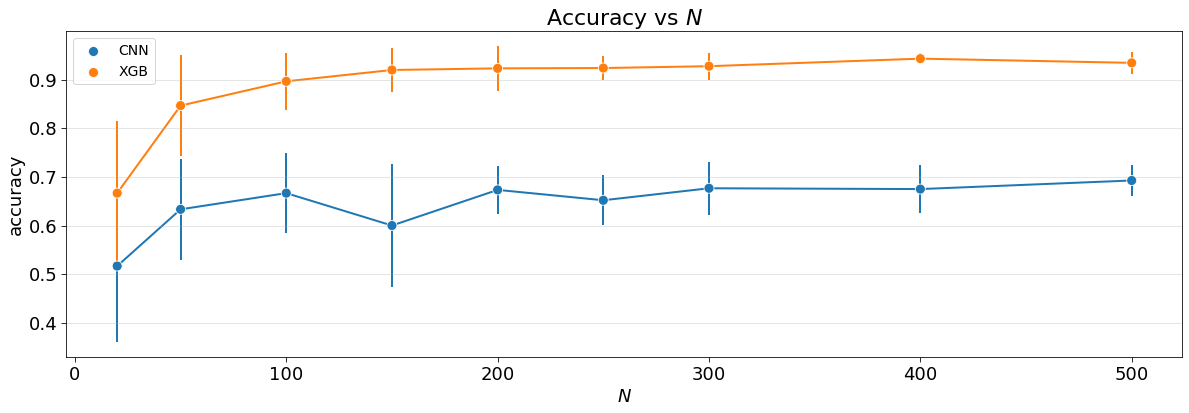

In [24]:
fig = plt.figure(figsize=(20,6)) 
ax = fig.add_subplot(111)

ax = plot_utils.scatter_results(
    parameter=N_list,
    result=[performance['cnn_mean_accuracy'] for performance in performance_list],
    error=[performance['cnn_std_accuracy'] for performance in performance_list],
    fig=fig,
    ax=ax,
    label="CNN",
    par_label="$N$",
    metric_label="accuracy",
    color="tab:blue",
    lw=2,
    ls="-",
    title="Accuracy vs $N$",
)

ax = plot_utils.scatter_results(
    parameter=N_list,
    result=[performance['xgb_mean_accuracy'] for performance in performance_list],
    error=[performance['xgb_std_accuracy'] for performance in performance_list],
    fig=fig,
    ax=ax,
    label="XGB",
    par_label="$N$",
    metric_label="accuracy",
    color="tab:orange",
    lw=2,
    ls="-",
    title="Accuracy vs $N$",
)

ax.set_axisbelow(True)
ax.grid("y", "major", axis="y", alpha=0.4)

plt.show()

In [ ]:
xgb_performance

[0.8333333333333334, 0.6666666666666666]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=452e6836-b7b8-455e-80d9-d4109b6baddf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>